In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master("local").appName("Irish Marine Institute - Data Prep").getOrCreate()

In [3]:
df = spark.read.csv("dataset/IrishNationalTideGaugeNetwork.csv", header=True, inferSchema=True)
df.show(vertical=True)

-RECORD 0------------------------------------
 time                 | UTC                  
 altitude             | m                    
 latitude             | degrees_north        
 longitude            | degrees_east         
 station_id           | null                 
 datasourceid         | null                 
 Water_Level_LAT      | metres               
 Water_Level_OD_Malin | metres               
 QC_Flag              | null                 
-RECORD 1------------------------------------
 time                 | 2006-10-26T13:00:00Z 
 altitude             | 0.0                  
 latitude             | 53.585               
 longitude            | -6.1081              
 station_id           | Skerries Harbour     
 datasourceid         | 11                   
 Water_Level_LAT      | 4.679                
 Water_Level_OD_Malin | 1.82                 
 QC_Flag              | 1                    
-RECORD 2------------------------------------
 time                 | 2006-10-26

In [4]:
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- station_id: string (nullable = true)
 |-- datasourceid: integer (nullable = true)
 |-- Water_Level_LAT: string (nullable = true)
 |-- Water_Level_OD_Malin: string (nullable = true)
 |-- QC_Flag: integer (nullable = true)



In [5]:
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import col
from pyspark.sql.functions import year, to_date
from pyspark.sql.functions import dayofmonth, month, year,hour, minute

df = df.filter((df.latitude == '53.585') & (df.longitude == '-6.1081'))
df = df.filter(df.Water_Level_OD_Malin < '5')
df = df.filter(df.Water_Level_OD_Malin > '-5')
df = df.withColumn("time", to_date(df.time))

df = df.na.drop()
df.show()
df.count()

+----------+--------+--------+---------+----------------+------------+---------------+--------------------+-------+
|      time|altitude|latitude|longitude|      station_id|datasourceid|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|
+----------+--------+--------+---------+----------------+------------+---------------+--------------------+-------+
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.679|                1.82|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.939|                2.08|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.969|                2.11|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.859|                 2.0|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.809|                1.95|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|  

347126

In [6]:
import pandas as pd
from pyspark.sql import SparkSession
from prophet import Prophet

pandas_df = df.select('time', 'Water_Level_OD_Malin').toPandas()
pandas_df = pandas_df.rename(columns={'time': 'ds', 'Water_Level_OD_Malin': 'y'})

model = Prophet()
model.fit(pandas_df)

future_dates = model.make_future_dataframe(periods=365) 
forecast = model.predict(future_dates)


17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2249,2022-01-12,1.013926,-0.088395,2.336917,1.013926,1.013926,0.081457,0.081457,0.081457,-0.003674,-0.003674,-0.003674,0.085131,0.085131,0.085131,0.0,0.0,0.0,1.095383
2250,2022-01-14,1.013801,-0.141160,2.363155,1.013801,1.013801,0.086281,0.086281,0.086281,0.012011,0.012011,0.012011,0.074270,0.074270,0.074270,0.0,0.0,0.0,1.100082
2251,2022-01-15,1.013739,-0.215780,2.325048,1.013739,1.013739,0.068115,0.068115,0.068115,-0.000194,-0.000194,-0.000194,0.068309,0.068309,0.068309,0.0,0.0,0.0,1.081854
2252,2022-01-16,1.013677,-0.162377,2.392942,1.013677,1.013677,0.066706,0.066706,0.066706,0.004596,0.004596,0.004596,0.062110,0.062110,0.062110,0.0,0.0,0.0,1.080382
2253,2022-01-17,1.013614,-0.209775,2.255445,1.013614,1.013614,0.051565,0.051565,0.051565,-0.004203,-0.004203,-0.004203,0.055767,0.055767,0.055767,0.0,0.0,0.0,1.065179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3090,2024-05-03,0.961407,-0.400216,2.157353,0.907867,1.024920,-0.062091,-0.062091,-0.062091,0.012011,0.012011,0.012011,-0.074102,-0.074102,-0.074102,0.0,0.0,0.0,0.899316
3091,2024-05-04,0.961344,-0.364520,2.138968,0.907608,1.025143,-0.070842,-0.070842,-0.070842,-0.000194,-0.000194,-0.000194,-0.070648,-0.070648,-0.070648,0.0,0.0,0.0,0.890503
3092,2024-05-05,0.961282,-0.356980,2.044601,0.907353,1.025367,-0.062909,-0.062909,-0.062909,0.004596,0.004596,0.004596,-0.067505,-0.067505,-0.067505,0.0,0.0,0.0,0.898373
3093,2024-05-06,0.961220,-0.369451,2.056827,0.907098,1.025577,-0.068941,-0.068941,-0.068941,-0.004203,-0.004203,-0.004203,-0.064738,-0.064738,-0.064738,0.0,0.0,0.0,0.892279


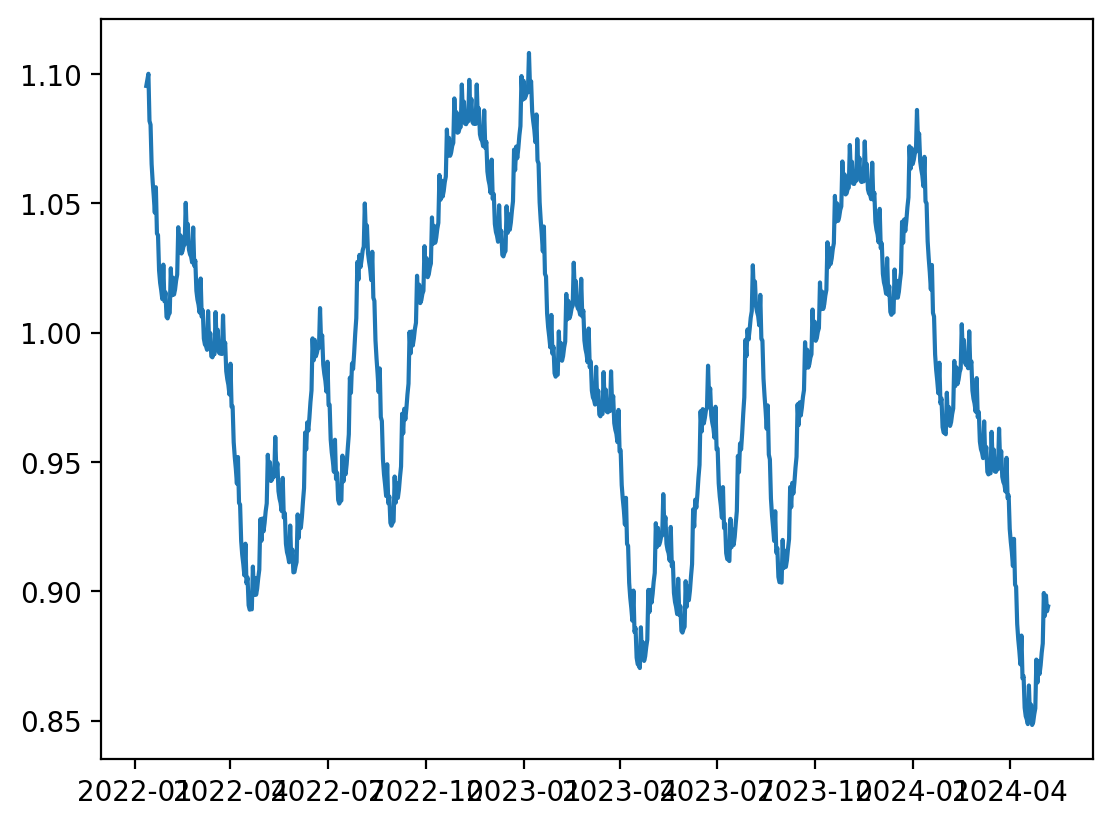

In [7]:
import matplotlib.pyplot as plt
from IPython.display import display
forecast_2023_onward = forecast[forecast["ds"].dt.year >= 2022]
display(forecast_2023_onward)
plt.plot(forecast_2023_onward.ds, forecast_2023_onward.yhat)

(-10.0, 10.0)

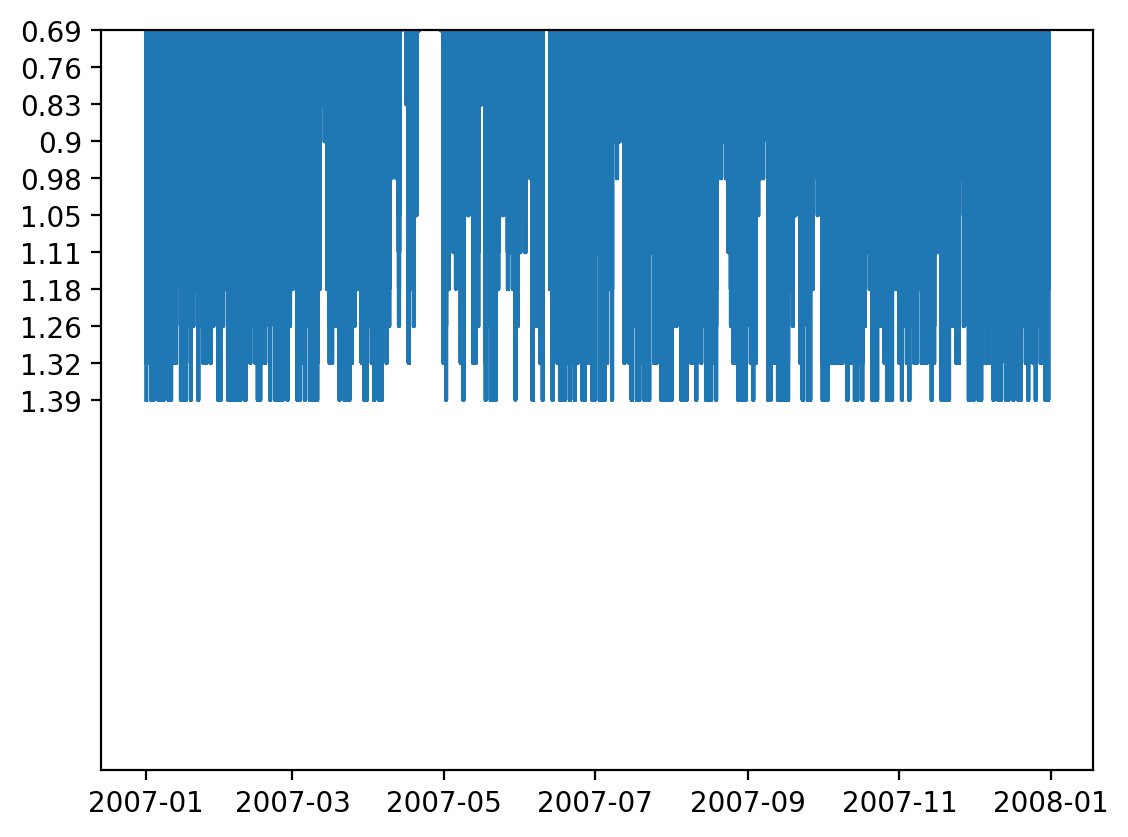

In [8]:
pandas_df["ds"] = pd.to_datetime(pandas_df["ds"])
filtered_data = pandas_df.loc[(pandas_df["ds"].dt.year > 2006) & (pandas_df["ds"].dt.year < 2008) ]
plt.ylim(-10, 10)
plt.plot(filtered_data.ds, filtered_data.y)